In [3]:
import earthaccess
import ipyleaflet
from ipywidgets import Dropdown

auth = earthaccess.login()

In [4]:
# ArcticDEM
# note that we need to use the same projection for the image service layer and the map.
m1 = ipyleaflet.Map(
    center=(90, 0),
    zoom=4,
    basemap=ipyleaflet.basemaps.Esri.ArcticOceanBase,
    crs=ipyleaflet.projections.EPSG5936.ESRIBasemap,
)
# add arctic ocean reference basemap
tl1 = ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.Esri.ArcticOceanReference)
m1.add(tl1)

# create a widget control for the raster function
raster_functions = [
    "Aspect Map",
    "Contour 25",
    "Hillshade Elevation Tinted",
    "Hillshade Gray",
    "Height Ellipsoidal",
    "Height Orthometric",
    "Slope Map"]
raster_dropdown1 = Dropdown(
    value=raster_functions[3],
    options=raster_functions,
    description="Raster:",
)

# add image service layer with ArcticDEM
url = 'https://elevation2.arcgis.com/arcgis/rest/services/Polar/ArcticDEM/ImageServer'
rendering_rule = {"rasterFunction": raster_dropdown1.value}
image_layer = ipyleaflet.ImageService(
    name="CustomBaseLayer",
    url=url,
    format='jpgpng', rendering_rule=rendering_rule,
    attribution='Esri, PGC, UMN, NSF, NGA, DigitalGlobe',
    crs=ipyleaflet.projections.EPSG5936.ESRIBasemap)

m1.add(image_layer) 

# add control for raster function
dropdown_control = ipyleaflet.WidgetControl(widget=raster_dropdown1, position="topright")
m1.add(dropdown_control)

# set the rendering rule
def set_raster_function(sender):
    image_layer.rendering_rule = {"rasterFunction": raster_dropdown1.value}
    # force redrawing of map by removing and adding layer
    m1.remove(image_layer)
    m1.add(image_layer)


# watch raster function widget for changes
raster_dropdown1.observe(set_raster_function)

In [5]:
sw = earthaccess.search_widget(map=m1)

In [7]:
polygon = [(-83.837578, 45.82529), (-80.167794, 45.82529), (-80.167794, 46.021921), (-83.837578, 46.021921), (-83.837578, 45.82529)]

if 'sw' in vars():
    if len(sw.roi) > 0:
        polygon = sw.roi

params = {
    "concept_id" : ["C2596864127-NSIDC_CPRD", "C2076090826-LPCLOUD", "C2237824918-ORNL_CLOUD"],
    "temporal": ("2021-01", "2023-09"),
    # "cloud_cover": (0, 20),
    "polygon": polygon
}
results = earthaccess.search_data(**params)
m = sw.explore(results)
# explore will inject its own controls so we add the base layer dropdown back
try:
    sw.map.add(dropdown_control)
except Exception:
    pass
m

Granules found: 2241


Map(bottom=2348.0, center=[90, 0], controls=(LayersControl(options=['position']), ZoomControl(options=['positi…

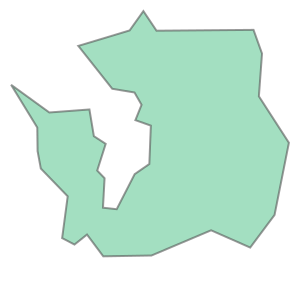

In [2]:
import requests
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

geojson = requests.get("https://www.glims.org/geoserver/GLIMS/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetFeatureInfo&FORMAT=application/json&TRANSPARENT=true&QUERY_LAYERS=GLIMS_GLACIERS&LAYERS=GLIMS_GLACIERS&INFO_FORMAT=application%2Fjson&FEATURE_COUNT=20&I=50&J=50&CRS=EPSG%3A3857&WIDTH=101&HEIGHT=101&BBOX=1509769.8507459976%2C5231269.001494909%2C1510734.8682280981%2C5232234.018977009").json()

polygon: Polygon = shape(geojson["features"][0]["geometry"])
polygon